## Regression Using BLiTZ (Bayesian Layers in Torch Zoo)
- Kind-of tutorial: https://towardsdatascience.com/blitz-a-bayesian-neural-network-library-for-pytorch-82f9998916c7
- Github repo: https://github.com/piEsposito/blitz-bayesian-deep-learning

## To install:
- `pip install blitz-bayesian-pytorch`

or:

- `conda install -c conda-forge blitz-bayesian-pytorch`

or: 

`conda create -n blitz python=3.9
conda activate blitz
git clone https://github.com/piEsposito/blitz-bayesian-deep-learning.git
cd blitz-bayesian-deep-learning
pip install .`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device = ",device)

if device.type == "cpu":
    cuda = False
else:
    cuda = True
    
import sys
sys.path.append('../../duq/')
  
# Importing the Bayesian LR module
import pre
import post
import sgld as SG
import pandas as pd
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

Device =  cpu
Device =  cpu


In [2]:
def f(x):
    """ Function to plot a damped sinusoid """ 
    A = 2         # Initial amplitude
    lamb = 0.2    # Decay constant
    w = 2         # Angular frequency
    phi = 0       # Phase angle at t=0
    flipped = False # Whether to flip the x axis or not
    if torch.is_tensor(x):
        res = A*torch.exp(-lamb*x)*(torch.cos(w*x+phi) + torch.sin(w*x + phi))
        if flipped:
            res = res.numpy()
            res = np.flip(res).copy()
            res = torch.Tensor(res)
        return res
    else:
        res = A*np.exp(-lamb*x)*(np.cos(w*x+phi) + np.sin(w*x + phi))
        if flipped: res = np.flip(res)
        return res

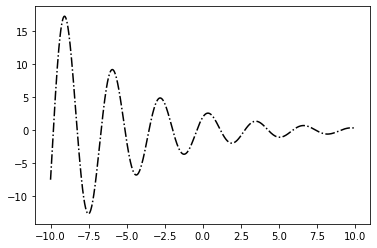

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-10,10,1000)
Y = f(X)

plt.plot(X,Y,'k-.')

df = pd.DataFrame({"X":X,"Y":Y})

x_cols=[0]
y_cols=[1]
component = 0 # Sort by the x component 
cutoff_percentile = (0.5,0.5)
val_split = 0.2
component_name = "Y"

df, data_mean, data_std = pre.process_df_euclid(df=df, x_cols=x_cols)

y_mean = data_mean[y_cols].values
x_mean = data_mean[x_cols].values
y_std = data_std[y_cols].values
x_std = data_std[x_cols].values

TRAIN, VAL, TEST = pre.split_data(df, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

In [4]:
num_epochs = 1000
batch_size = len(x_train)
num_units = 300
lr = 5e-4

In [5]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, num_units)
        self.blinear2 = BayesianLinear(num_units, num_units)
        self.blinear3 = BayesianLinear(num_units, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        x_ = self.blinear2(x_)
        X_ = F.relu(x_)
        return self.blinear3(x_)

In [6]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 300,
                        std_multiplier = 2):
    with torch.no_grad():
        preds = [regressor(X) for i in range(samples)]
        preds = torch.stack(preds)
        means = preds.mean(axis=0)
        stds = preds.std(axis=0)
        ci_upper = means + (std_multiplier * stds)
        ci_lower = means - (std_multiplier * stds)
        ic_acc = (ci_lower <= y) * (ci_upper >= y)
        ic_acc = ic_acc.float().mean()
        return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

In [7]:
regressor = BayesianRegressor(input_dim = 1,
                              output_dim = 1,
                              num_units = num_units).to(device)
optimizer = optim.Adam(regressor.parameters(), lr= lr)   # This is what the example came with
criterion = torch.nn.MSELoss()

ds_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(x_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [8]:
iteration = 0
for epoch in range(num_epochs):
    if epoch%100 == 0:
        print(f"Epoch {epoch}")
    for i, (x, y) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=x.to(device),
                           labels=y.to(device),
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=1/x_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%500==0:
            #ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
            #                                                            x_test.to(device),
            #                                                            y_test.to(device),
            #                                                            samples=25,
            #                                                            std_multiplier=3)
            
            #print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            print("Loss: {:.4f}".format(loss))

Epoch 0
Loss: 1875.5254
Loss: 1827.4928
Epoch 100
Loss: 1783.9760
Loss: 1740.4652
Loss: 1699.1328
Epoch 200
Loss: 1655.2897
Loss: 1612.4570
Epoch 300
Loss: 1568.9191
Loss: 1525.3375
Loss: 1482.0049
Epoch 400
Loss: 1439.6504
Loss: 1396.0284
Loss: 1352.7034
Epoch 500
Loss: 1309.2643
Loss: 1267.1542
Epoch 600
Loss: 1223.9147
Loss: 1181.2880
Loss: 1138.1620
Epoch 700
Loss: 1095.6554
Loss: 1051.8165
Epoch 800
Loss: 1009.3997
Loss: 967.5200
Loss: 924.6946
Epoch 900
Loss: 882.1816
Loss: 841.6609
Loss: 797.3250


In [9]:
def generate_samples(X, y_mean, y_std, num_tests):
    samples = []
    with torch.no_grad():
        samples = [regressor(x_test) for i in range(num_tests)]
        samples = torch.stack(samples)
        samples = pre.unnormalise(samples, y_mean, y_std)
    
    means = samples.mean(axis=0).squeeze(1).data.numpy()
    stds = samples.std(axis=0).squeeze(1).data.numpy()
    return samples, means, stds

def run_sampling(X, Y, num_tests):
    samples, means, stds= generate_samples(X, y_mean, y_std, num_tests) 

    samples = np.squeeze(samples)

    Y_np = pre.unnormalise(Y.squeeze().numpy(), y_mean, y_std)
    return samples, means, stds, Y_np

num_tests=500
samples_full, means_full, stds_full, y_train_np_full = run_sampling(torch.Tensor(df["X"]).unsqueeze(1), torch.Tensor(df["Y"]).unsqueeze(1), num_tests)
means_full_, stds_full_, x_full_ = post.sort_data([means_full.squeeze(), stds_full.squeeze(), df["X"]], sortby=2)

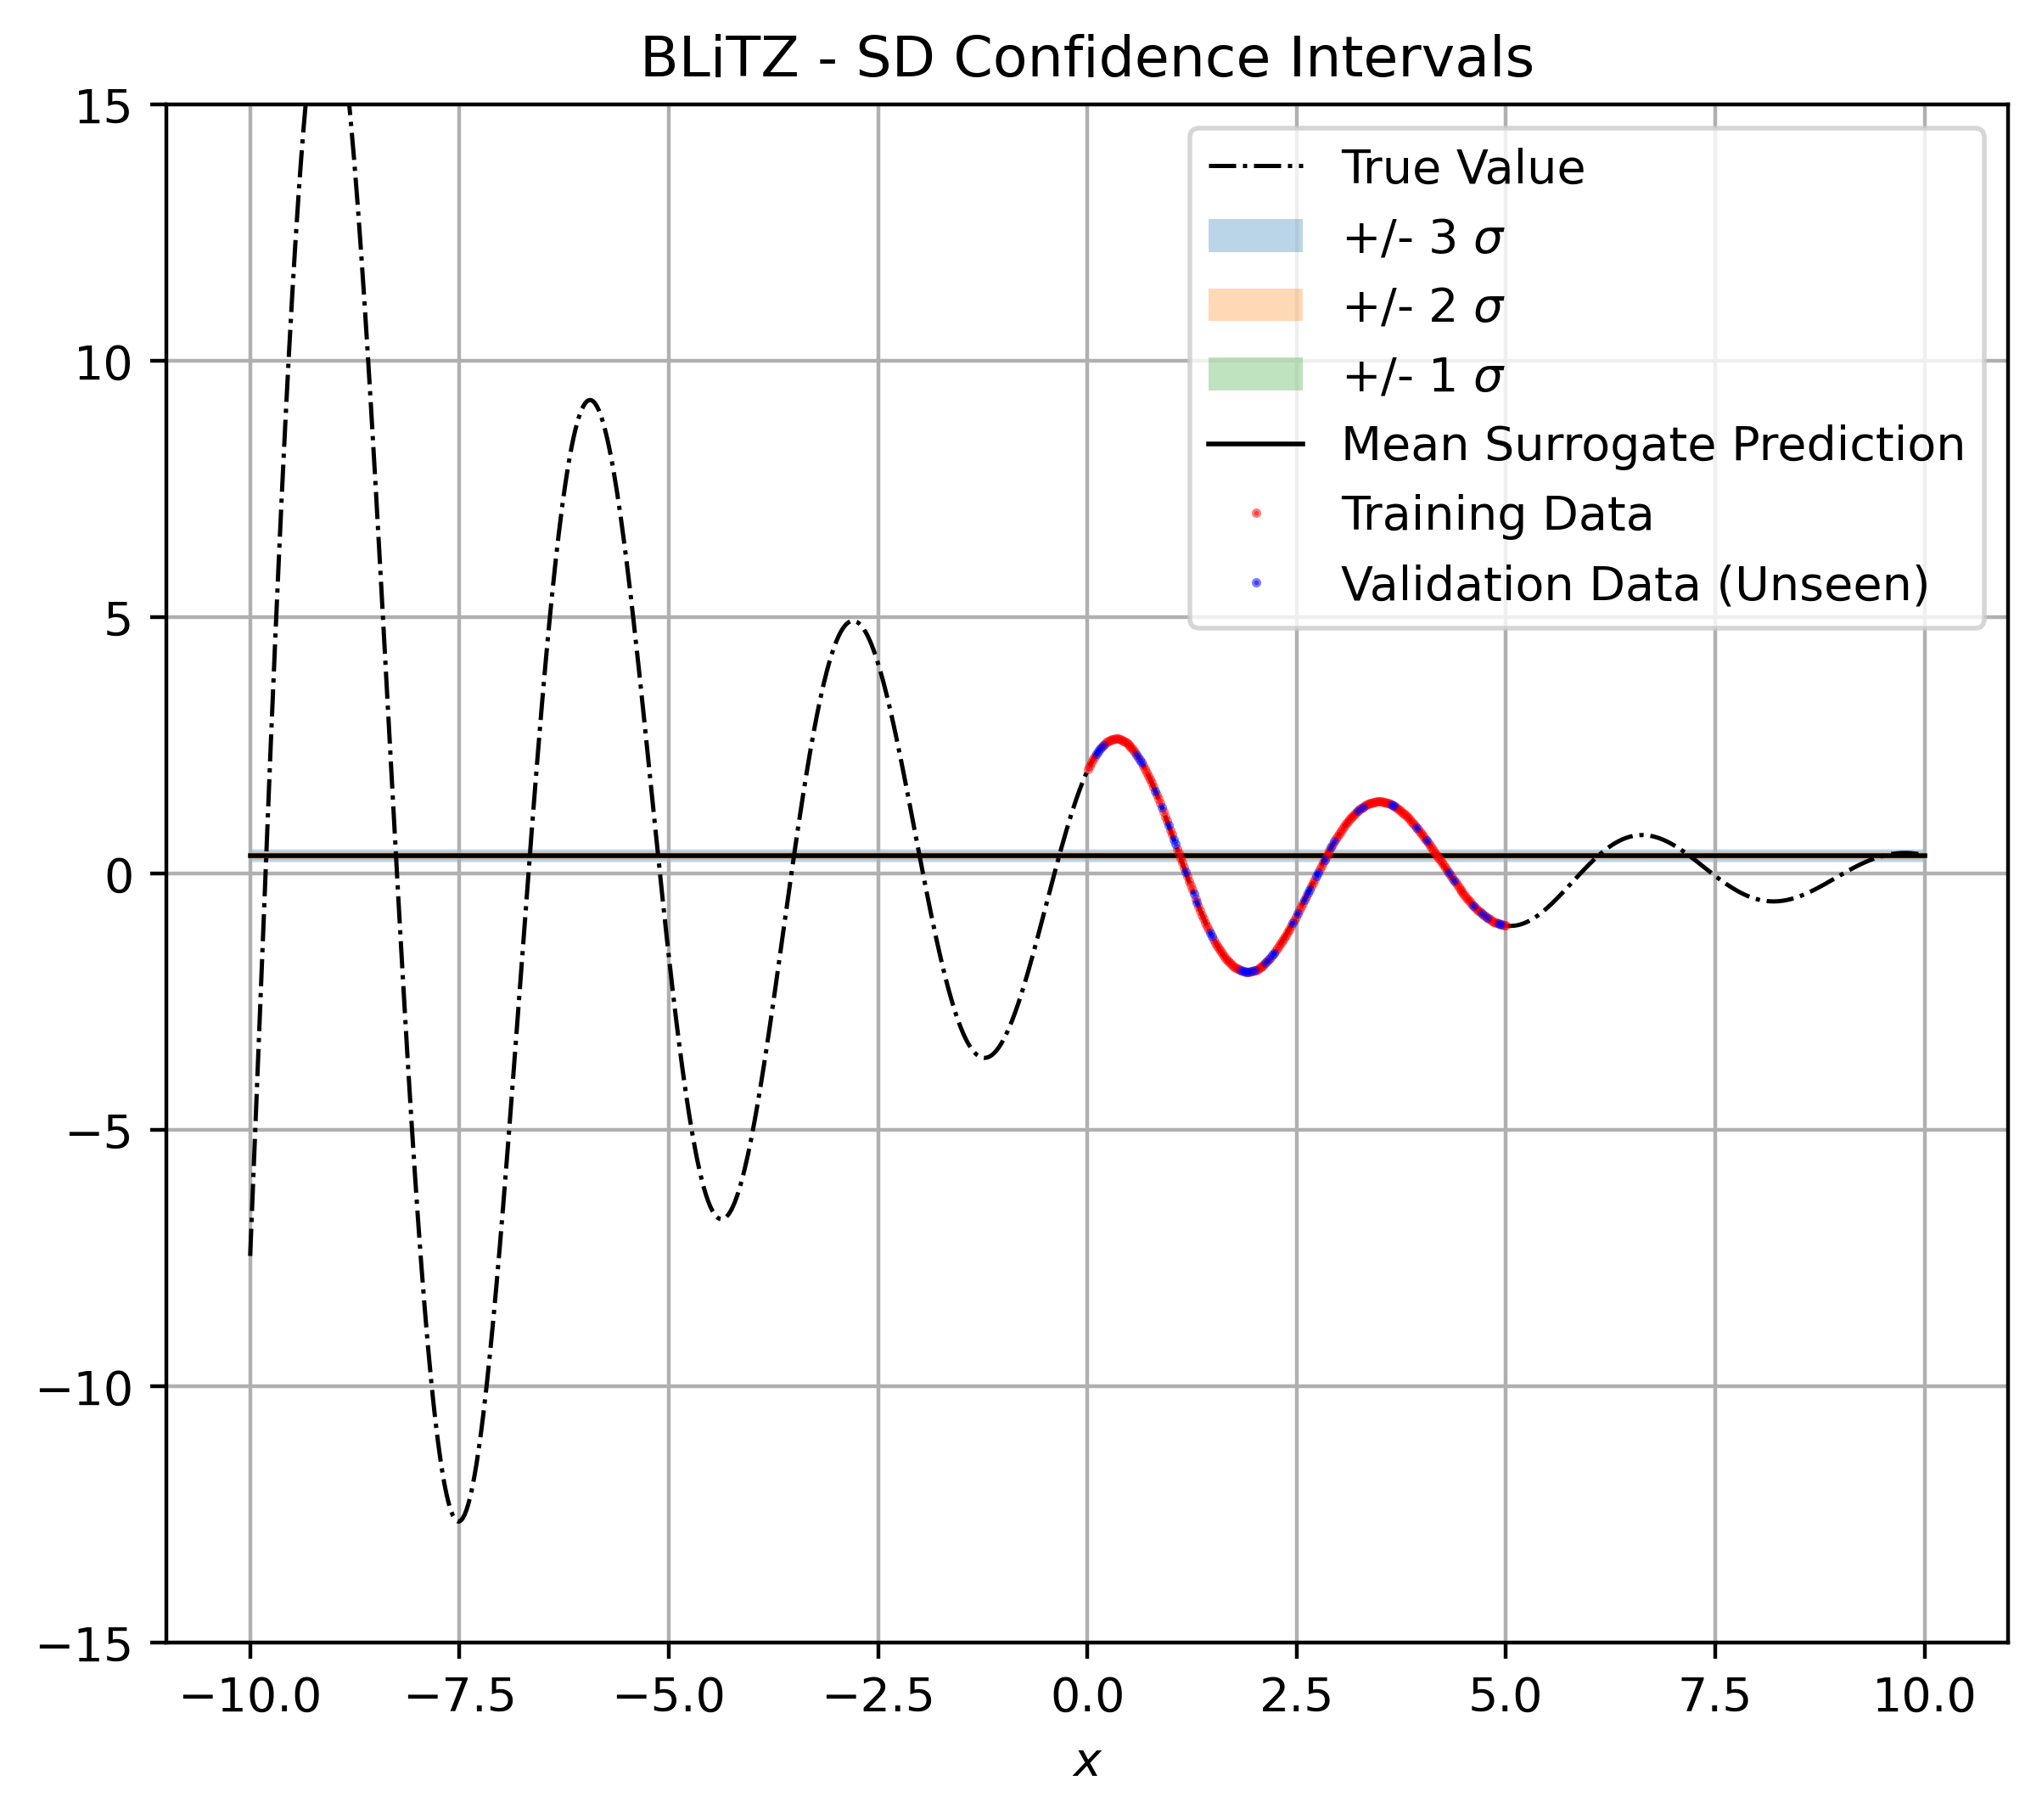

In [16]:

plt.figure(figsize=(7,6), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.fill_between(X, means_full_.ravel() + 3*stds_full_.flatten(), means_full_.ravel() - 3*stds_full_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 2*stds_full_.flatten(), means_full_.ravel() - 2*stds_full_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 1*stds_full_.flatten(), means_full_.ravel() - 1*stds_full_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
#plt.plot(X[test_indices], Y[test_indices], 'oy', alpha=0.5, markersize=3, label="Test Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('BLiTZ - SD Confidence Intervals')
plt.show()

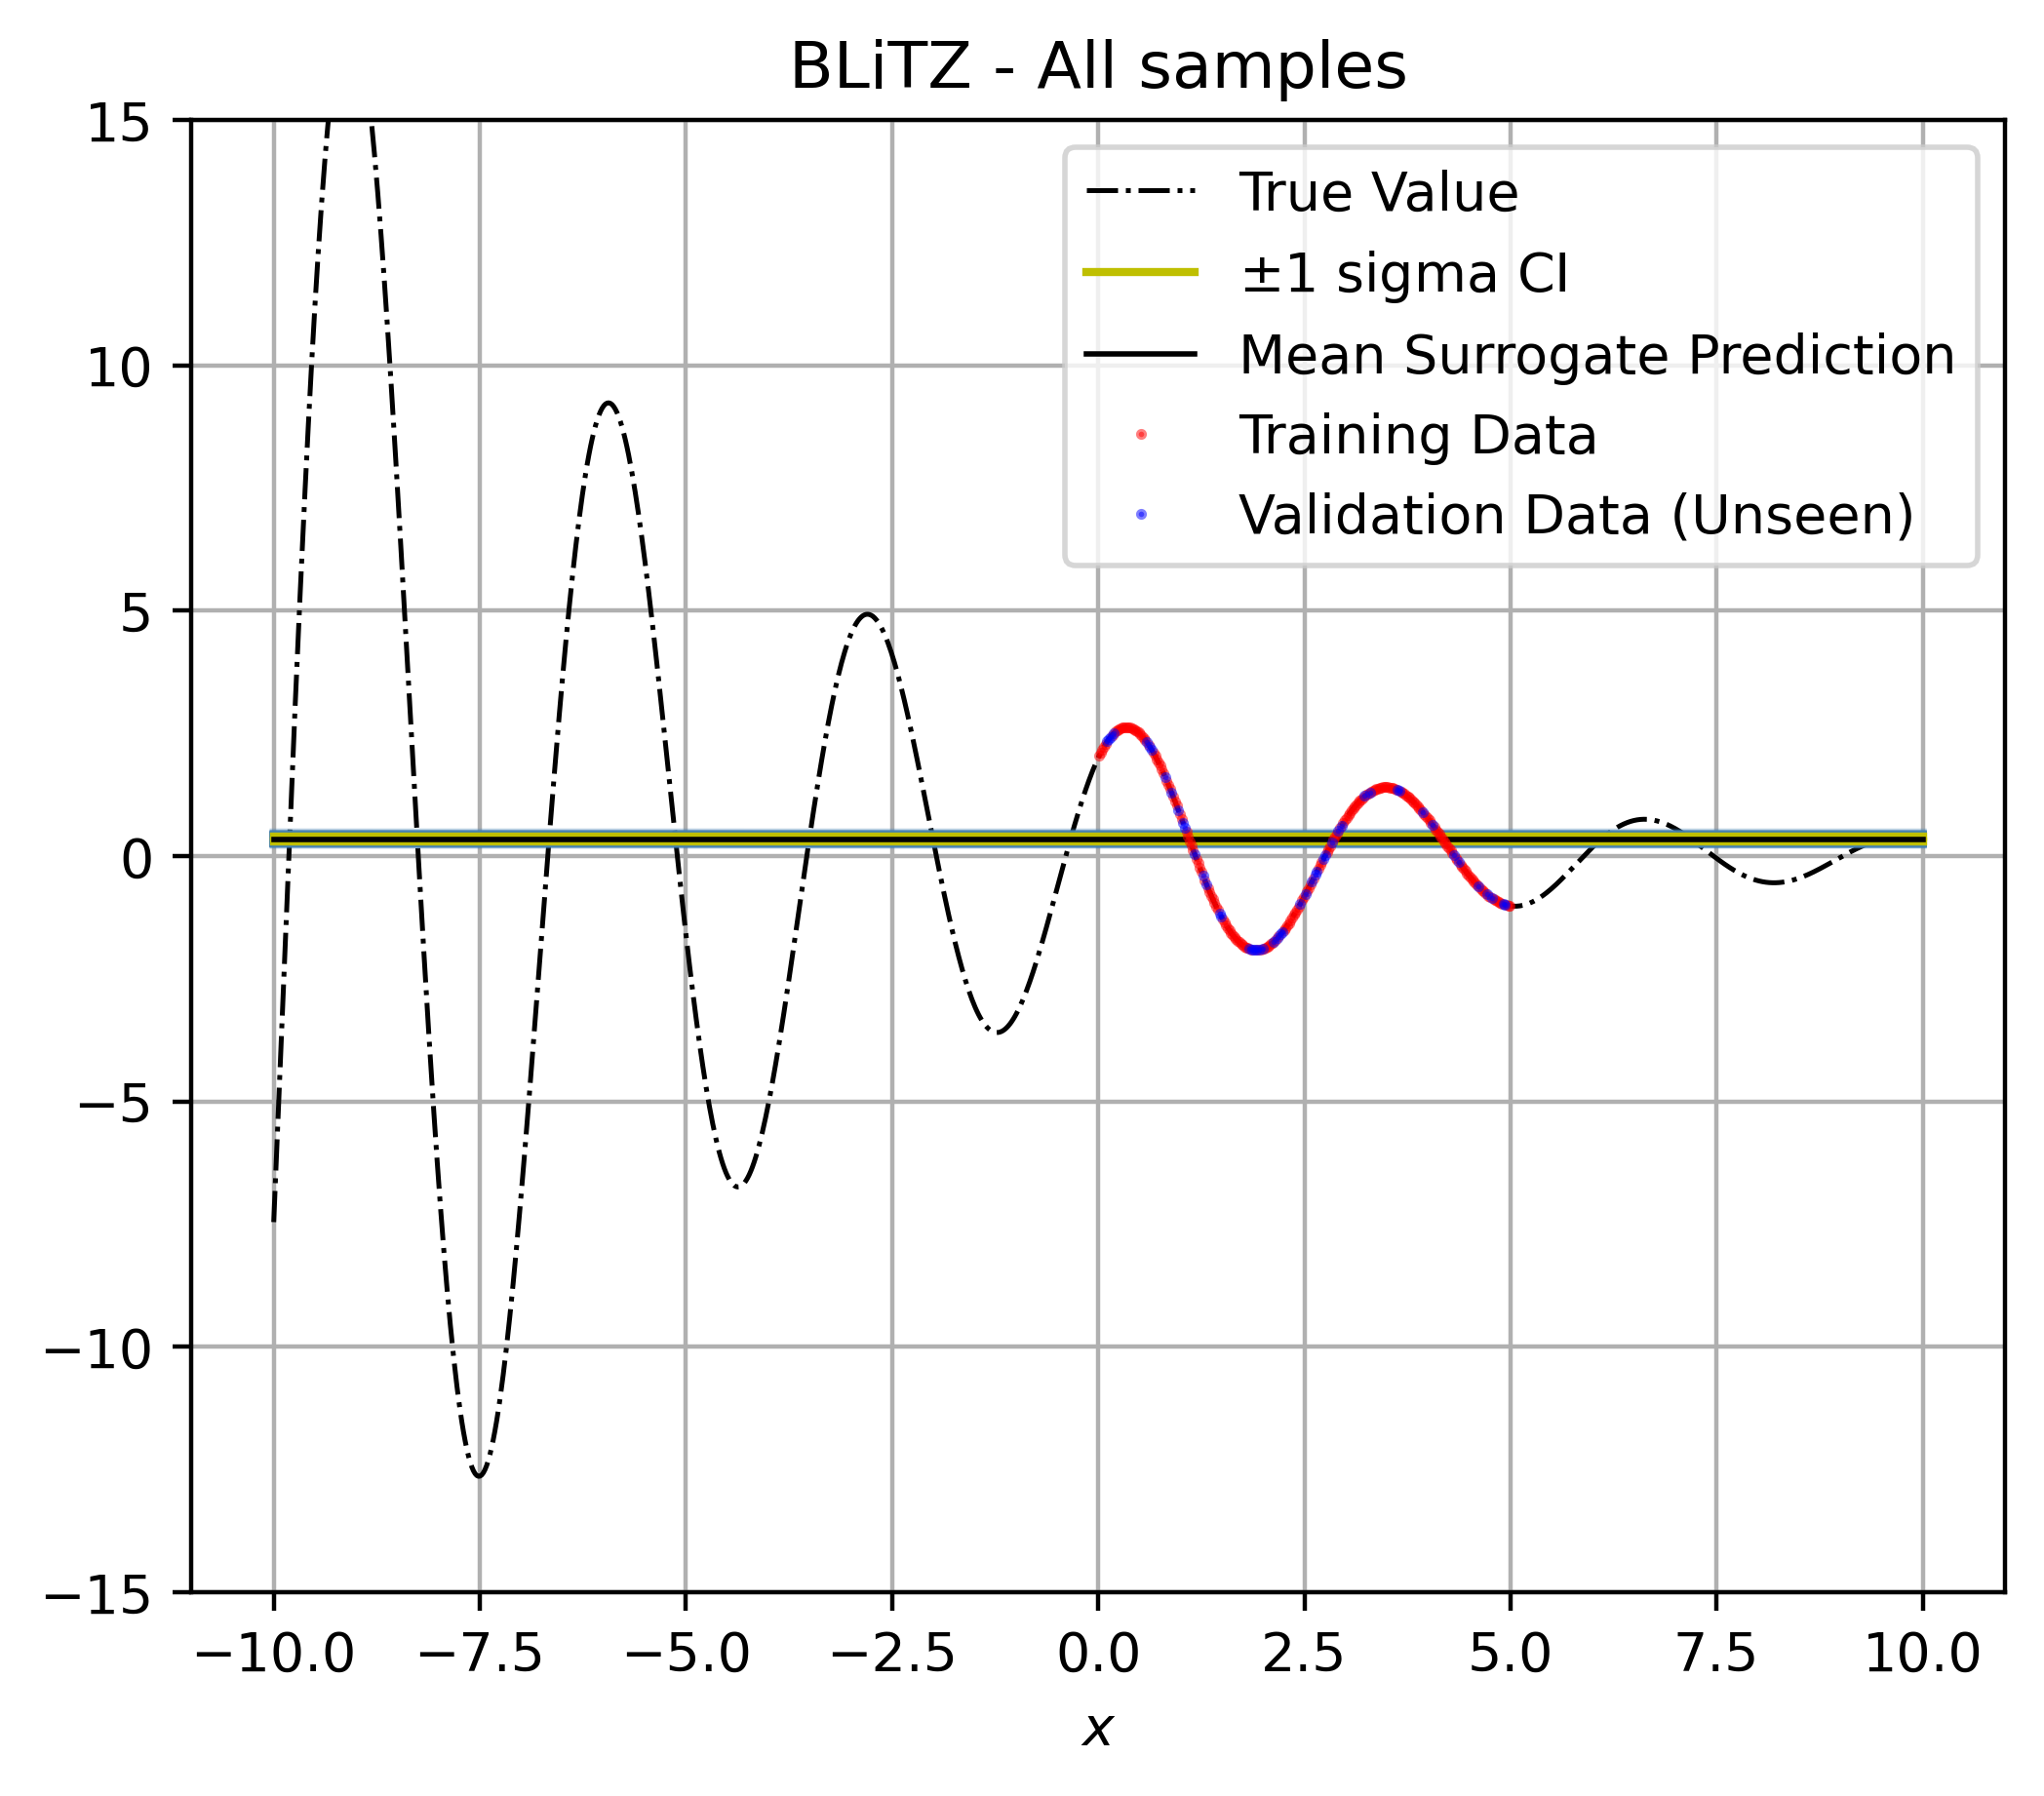

In [17]:
plt.figure(figsize=(6,5), dpi=400)
plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.plot(X, samples_full[:].T,'steelblue',alpha=0.2)
plt.plot(X, means_full_.ravel() + 1*stds_full_.flatten(),'y',label="$\pm$1 sigma CI")
plt.plot(X, means_full_.ravel() - 1*stds_full_.flatten(),'y')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('BLiTZ - All samples')
plt.show()